2025-08-05 15:28:58.854181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754407739.126301      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754407739.211816      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Step 1: Setting up configuration
--> Using device: cpu
--> Loaded 8 unique colors.

Step 2: Loading the trained model
--> Model directory: /kaggle/input/best-model-diffusers-2-0
--> Loading weights from: /kaggle/input/best-model-diffusers-2-0/diffusion_pytorch_model-2.safetensors
Model loaded successfully!

Step 3: Defining helper functions
Helper functions are ready.

Step 4: Looping through validation set


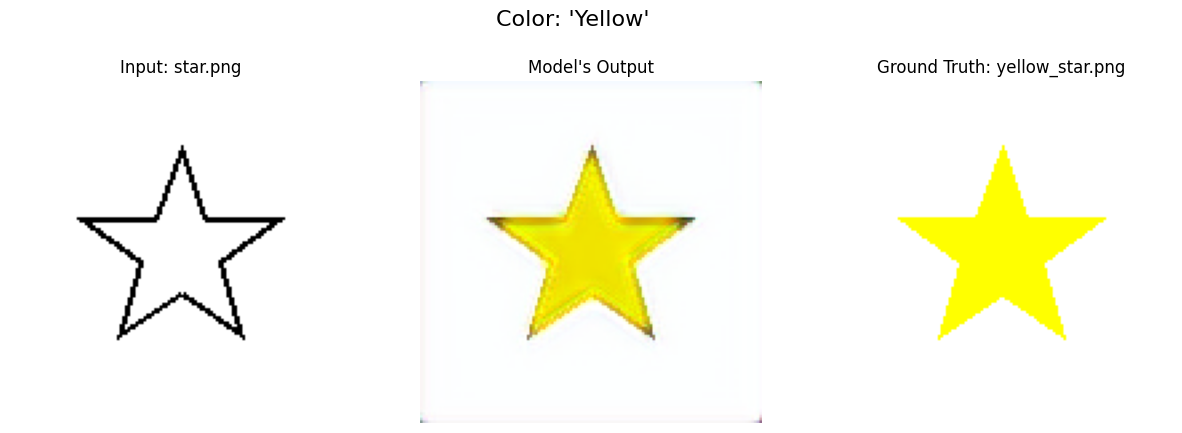

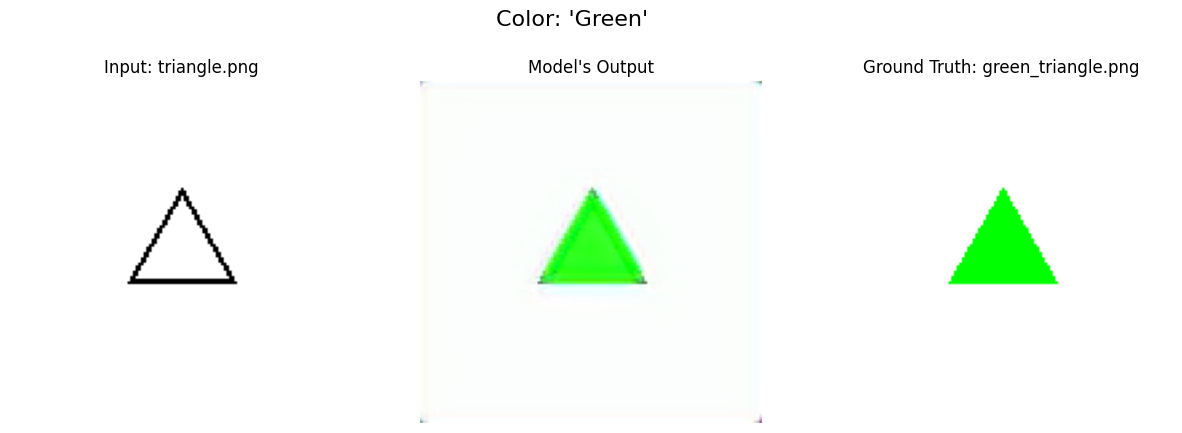

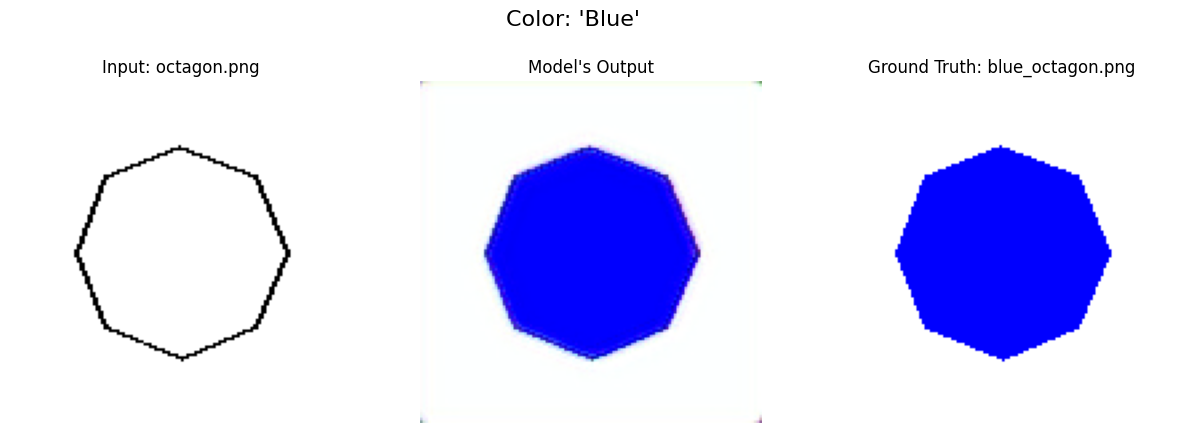

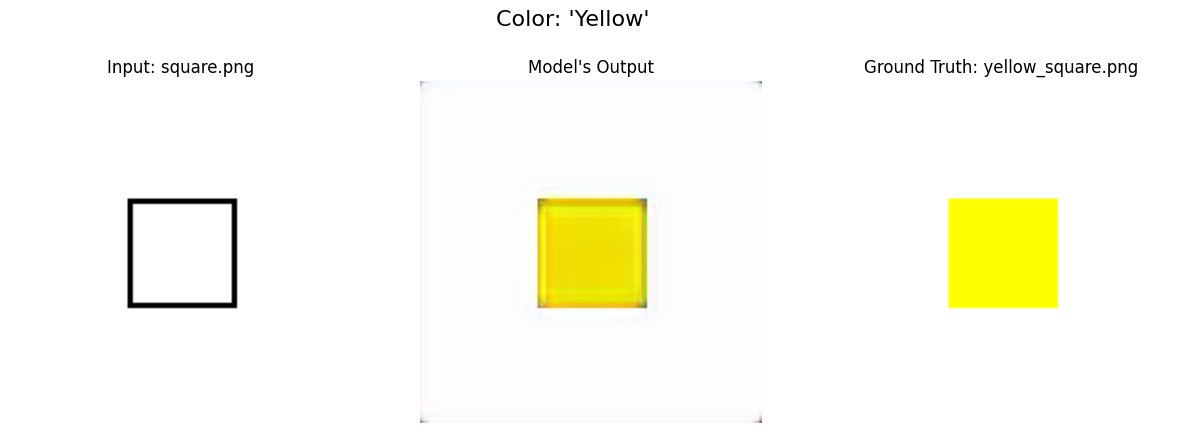

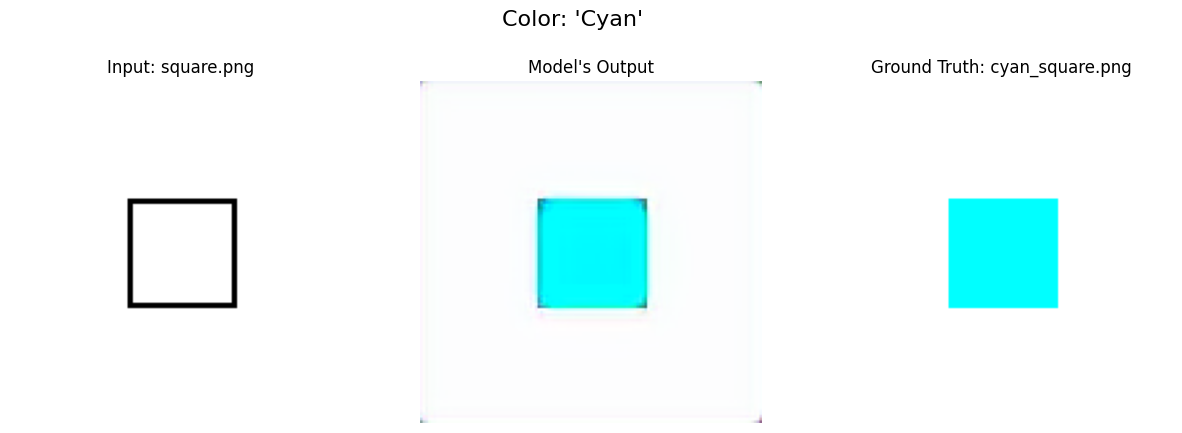

In [1]:
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from diffusers import UNet2DConditionModel
import torchvision.transforms as transforms


print("Step 1: Setting up configuration")
CONFIG = {
    "img_size": 128,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dataset_path": "/kaggle/input/ayna-dataset-full/dataset",
}
train_json_path = os.path.join(CONFIG['dataset_path'], 'training', 'data.json')
with open(train_json_path, 'r') as f:
    train_data = json.load(f)
all_colors = sorted(list(set(item['colour'] for item in train_data)))
color_to_idx = {color: i for i, color in enumerate(all_colors)}
NUM_COLORS = len(all_colors)
print(f"--> Using device: {CONFIG['device']}")
print(f"--> Loaded {NUM_COLORS} unique colors.")


print("\nStep 2: Loading the trained model")
model_dir = "/kaggle/input/best-model-diffusers-2-0"
print(f"--> Model directory: {model_dir}")

try:
    # Load model configuration
    config_path = os.path.join(model_dir, 'config.json')
    with open(config_path, 'r') as f:
        model_config = json.load(f)

    model = UNet2DConditionModel(**model_config)

    weights_path = os.path.join(model_dir, 'diffusion_pytorch_model-2.safetensors')
    print(f"--> Loading weights from: {weights_path}")
    
    # Load the weights into the model
    state_dict = load_file(weights_path, device=CONFIG['device'])
    model.load_state_dict(state_dict)
    
    model.to(CONFIG['device'])
    model.eval()
    
    print("Model loaded successfully!")

except Exception as e:
    print(f"ERROR in Step 2 while loading the model: {e}")


print("\nStep 3: Defining helper functions")
inference_transforms = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
])

def generate_colored_polygon(model, image_path, color_name, config, color_map, num_colors, device):
    try:
        input_image_pil = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"--> ERROR: Input image not found at {image_path}")
        return None, None
    input_tensor = inference_transforms(input_image_pil).unsqueeze(0).to(device)
    if color_name not in color_map:
        print(f"--> ERROR: Color '{color_name}' is not valid.")
        return input_image_pil, None
    color_idx = torch.tensor([color_map[color_name]], device=device)
    color_cond = F.one_hot(color_idx, num_classes=num_colors).float().unsqueeze(1).to(device)
    with torch.no_grad():
        output = model(sample=input_tensor, timestep=1, encoder_hidden_states=color_cond).sample
    output_tensor = output.detach().cpu().squeeze(0)
    output_tensor = torch.clamp(output_tensor, 0, 1)
    output_image = transforms.ToPILImage()(output_tensor)
    return input_image_pil, output_image
print("Helper functions are ready.")

print("\nStep 4: Looping through validation set")

val_dir = os.path.join(CONFIG['dataset_path'], 'validation')
val_json_path = os.path.join(val_dir, 'data.json')

with open(val_json_path, 'r') as f:
    validation_data = json.load(f)

if 'model' in locals():
    for item in validation_data:
        input_filename = item['input_polygon']
        output_filename = item['output_image']
        color_name = item['colour']
        
        input_image_path = os.path.join(val_dir, 'inputs', input_filename)
        ground_truth_path = os.path.join(val_dir, 'outputs', output_filename)
        
        # Generate the output from your model
        input_img, generated_img = generate_colored_polygon(
            model=model,
            image_path=input_image_path,
            color_name=color_name,
            config=CONFIG,
            color_map=color_to_idx,
            num_colors=NUM_COLORS,
            device=CONFIG['device']
        )
        
        ground_truth_img = Image.open(ground_truth_path)
    
        if input_img and generated_img:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f"Color: '{color_name.capitalize()}'", fontsize=16)
            
            axes[0].imshow(input_img)
            axes[0].set_title(f"Input: {input_filename}")
            axes[0].axis('off')
            
            axes[1].imshow(generated_img)
            axes[1].set_title("Model's Output")
            axes[1].axis('off')

            axes[2].imshow(ground_truth_img)
            axes[2].set_title(f"Ground Truth: {output_filename}")
            axes[2].axis('off')
            
            plt.show()

else:
    print("Could not run because the 'model' was not defined. Please review errors in Step 2.")